# Imports and dataset loading

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn import linear_model
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
import pandas as pd


strategyArray = []
gainArray     = []
lossArray     = []

originalDataSet = pd.read_csv('dataset', sep = ',',header = None)
scaler = MinMaxScaler()

def loadDataset():    
    scaler.fit(originalDataSet.sample(frac=1).values.reshape(-1, 1))
    dataSet = scaler.transform(originalDataSet.values) 
    
    features, result = np.array(dataSet[:, :4]), np.array(dataSet[:, 4:])
    return features, result

def invertNorm(value):
    auxArray = np.array([value, 0, 0, 0, 0, 0]).reshape(-1, 1)
    return scaler.inverse_transform(auxArray)[0][0]
    
def getError(value1, value2):
    return abs(invertNorm(value1) - invertNorm(value2))

Using TensorFlow backend.


# Cross validation function

In [2]:
def crossValidate(regressor, features, result, folds = 5):
    foldSize   = math.ceil(features.shape[0] / folds)
    gainErrors = []
    lossErrors = []
    
    for i in range(folds): 
        sliceBegin = i * foldSize
        sliceEnd   = (i + 1) * foldSize
        
        X_train = np.delete(features, np.s_[sliceBegin: sliceEnd], 0)
        y_train = np.delete(result, np.s_[sliceBegin: sliceEnd], 0)
        
        if isinstance(regressor, Sequential):
            regressor.fit(X_train, y_train, epochs = 500, verbose = 0)  
        else:
            regressor.fit(X_train, y_train)
            
        X_test = features[sliceBegin: sliceEnd]
        y_test = result[sliceBegin: sliceEnd]
        
        gainError = 0
        lossError = 0
        
        prediction = regressor.predict(X_test)
        
        for predicted, expected in zip(prediction, y_test):
            #print("Gain: ", invertNorm(predicted[0]), round(invertNorm(expected[0]), 14))
            #print("Loss: ", invertNorm(predicted[1]), round(invertNorm(expected[1]), 14))
            gainError += getError(predicted[0], expected[0])
            lossError += getError(predicted[1], expected[1])
            
        gainErrors.append(gainError / foldSize)
        lossErrors.append(lossError / foldSize)
        
        if isinstance(regressor, Sequential):
            regressor = setANN()

    return np.array(gainErrors), np.array(lossErrors)

In [3]:
def trainModel(strategy):   
    features, result = loadDataset()
    
    gainErrors, lossErrors = crossValidate(strategy, features, result)

    print(gainErrors, "=> %0.2f (+/- %0.2f)" % (np.mean(gainErrors), gainErrors.std() * 2))
    print(lossErrors, "=> %0.2f (+/- %0.2f)" % (np.mean(lossErrors), lossErrors.std() * 2))
    
    gainArray.append(gainErrors)
    lossArray.append(lossErrors)
    
    return gainErrors, lossErrors

In [4]:
def setANN():
    model = Sequential()
    
    model.add(Dense(4, input_dim = 4, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(6, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(8, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(6, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(2, kernel_initializer = 'normal', activation = 'sigmoid'))

    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Plotting functions

In [5]:
def plotGainError():
    fig, axis = plt.subplots(figsize = (10, 5))
    data       = gainArray

    print(strategyArray)
    axis.boxplot(data)
    axis.set_title("Gain error")
    axis.set_xticklabels(np.repeat(strategyArray, 1))
    axis.set_ylabel("Absolute error")

    plt.show()

In [6]:
def plotLossError():
    fig, axis = plt.subplots(figsize = (10, 5))
    data       = lossArray

    axis.boxplot(data)
    axis.set_title("Loss error")
    axis.set_xticklabels(np.repeat(strategyArray, 1))
    axis.set_ylabel("Absolute error")

    plt.show()

# Putting all together

In [7]:
gainArray = []
lossArray = []

In [8]:
linearSVR = MultiOutputRegressor(SVR(kernel = "rbf", C = 1.0, gamma = 'scale', epsilon = 0.2))
trainModel(linearSVR)
strategyArray.append("SVR (Linear)")

[3.64756447 3.16045845 3.00286533 3.02005731 2.6991404 ] => 3.11 (+/- 0.62)
[5.6747851  6.41547278 6.11747851 6.34097421 6.59885387] => 6.23 (+/- 0.63)


In [9]:
ridge = MultiOutputRegressor(KernelRidge(alpha=1.0))
trainModel(ridge)
strategyArray.append("Ridge")

[5.25059772 3.92860042 4.07387309 3.73336383 5.48161398] => 4.49 (+/- 1.45)
[3.29281446 2.36629772 2.82034427 2.35385697 3.59115349] => 2.88 (+/- 0.99)


In [10]:
lasso = MultiOutputRegressor(linear_model.Lasso(alpha = 0.2))
trainModel(lasso)
strategyArray.append("Lasso")

[3.36112388 3.05026437 2.79273569 3.01764353 2.76805609] => 3.00 (+/- 0.43)
[2.08823819 1.63738803 1.92714756 1.54396926 1.37129827] => 1.71 (+/- 0.52)


In [11]:
lars = MultiOutputRegressor(linear_model.Lars(n_nonzero_coefs=1))
trainModel(lars)
strategyArray.append("Least Angle Regression")

[3.23932525 3.01925407 2.71968479 2.99235276 2.82927157] => 2.96 (+/- 0.35)
[2.06273749 1.65246133 1.92058333 1.54309612 1.31281411] => 1.70 (+/- 0.53)


In [12]:
Huber = MultiOutputRegressor(linear_model.HuberRegressor())
trainModel(Huber)
strategyArray.append("Huber")

[2.97767521 2.93123775 2.61973303 2.92574289 3.62482412] => 3.02 (+/- 0.66)
[2.07674289 1.52407454 1.85297885 1.4371393  1.19961188] => 1.62 (+/- 0.62)


In [13]:
trainModel(setANN())
strategyArray.append("ANN")

[3.2234292  3.04369438 2.82352632 2.9954063  2.7063888 ] => 2.96 (+/- 0.36)
[2.08437239 1.59208399 1.90613295 1.49027458 1.30205867] => 1.67 (+/- 0.57)


# Plotting error boxplots

['SVR (Linear)', 'Ridge', 'Lasso', 'Least Angle Regression', 'Huber', 'ANN']


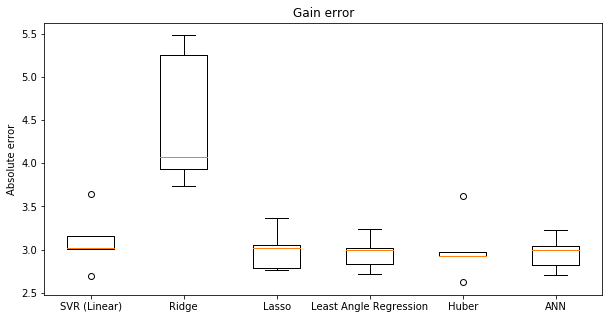

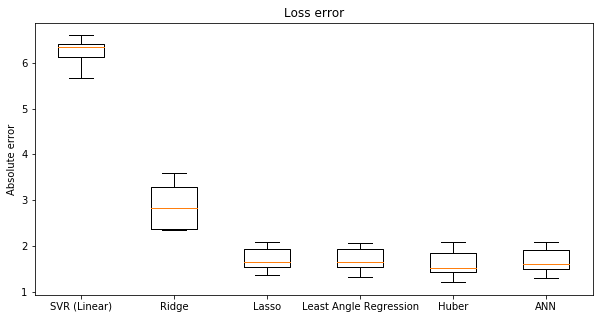

In [14]:
plotGainError()
plotLossError()